# Setup

In [ ]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="3"

# Generate Data

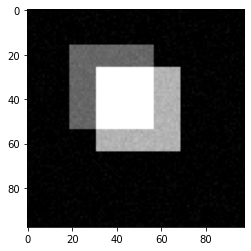

In [ ]:
input = np.zeros((33, 33))
input[2, 5] = 0.4
input[12, 17] = 0.7

a,b= np.meshgrid(np.linspace(-1, 1, 66), np.linspace(-1, 1, 66))
rectangle = np.array(np.logical_and(np.abs(a) < 0.6, np.abs(b) < 0.6),dtype='float32') 

Img = scipy.signal.convolve2d(input, rectangle)
plt.imshow(Img)

#IMG=np.stack((Img,) * 1, axis=-1)
IMG_T=torch.FloatTensor(Img)
IMG_T.shape
IMG_T2 = torch.unsqueeze(IMG_T, dim=0)
IMG_T2.shape
noisyImg = np.clip(Img + np.random.normal(scale=0.02, size=IMG_T2.shape), 0, 1).astype(np.float32) # adding noise from normal distribution
noisyImg_T=torch.FloatTensor(noisyImg)
noisyImg_T.shape
plt.imshow(noisyImg_T[0], cmap='gray')
clean=IMG_T2.unsqueeze(0)
noisy=noisyImg_T.unsqueeze(0)

In [ ]:
clean.shape

torch.Size([1, 1, 98, 98])

In [ ]:
noisy.shape

torch.Size([1, 1, 98, 98])

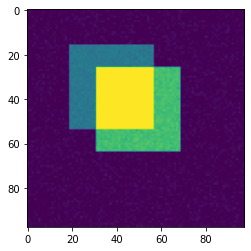

In [ ]:
plt.imshow(noisy[0][0])

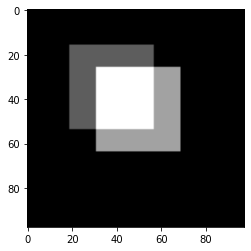

In [ ]:
plt.imshow(clean[0][0], cmap='gray')

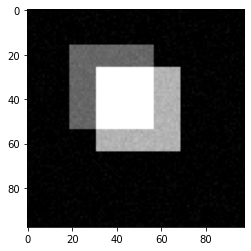

In [ ]:
plt.imshow(noisy[0][0], cmap='gray')

In [ ]:
torch.max(noisy)

tensor(1.)

In [ ]:
class Anet(nn.Module):
    def __init__(self, channel=8):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(97,1),padding=(48,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,97),padding=(0,48), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =F.relu(self.conv1(x))
        out = F.relu(self.conv2(x1))
        #out = self.conv2(x1)
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 98, 98)
A_net(x).shape

torch.Size([1, 1, 98, 98])

In [ ]:
from zmq import device
## reshape the tensors to a matrix

## inner dim =8
[8, 1, 98, 1]
[1,8, 1, 98]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV

## getting singular values

def my_singular(U, V):
  UV=my_outer(U, V)
  return np.array(torch.linalg.svdvals(UV).to('cpu').detach())
   
  

 #def my_svd(U,V):
    #UV=my_outer(U, V)
    #A,S,B= np.array(torch.svd_lowrank(UV, q=8, niter=2, M=None).to('cpu').detach())
    #return A,S,B



def Nuc_norm(U,V):
    sigma_vec= my_singular(U, V)
    return np.sum(sigma_vec)


In [ ]:
def plot_epoch(recon_np,noisyImg1, Img):
  #if i % 50 == 0:
    fig = plt.figure(figsize=(7, 7))
    rows = 2
    columns = 2
    plt.subplot(rows, columns, 1)
    #recon_np = recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy()
    plt.imshow(recon_np, cmap='gray')
    plt.axis('off')
    plt.title("recon")
    plt.subplot(rows, columns, 2)
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.title("Img")
    plt.subplot(rows, columns, 3)
    plt.imshow(noisyImg1, cmap='gray')
    plt.axis('off')
    plt.title("Img+Noise")
    plt.show()
    plt.show()

> ### Training Function








In [ ]:
def recon(noisy, clean, alpha=0., iterations=100000, lr=1.e-2, gpu=True):
  import time

  cuda = torch.device('cuda') 

  A_net = Anet()
  x = torch.randn(1, 1, 98, 98)

  if gpu:
    A_net = A_net.to(cuda)
    x = x.to(cuda)
    noisy = noisy.to(cuda)
    clean = clean.to(cuda)

    #U=U.to(cuda)
    #V=V.to(cuda)
  
  optimizer = optim.SGD(A_net.parameters(), lr=lr)

  Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = [],[], [], [], [],[], [], [], [], [],[]

  start = time.time()
  for i in tqdm(range(iterations)):

    recon = A_net(x)
    
    l2_norm = sum(p.pow(2.0).sum() for p in A_net.parameters()) #L2 norm of weights (p**2)
    U, V=[ p for p in A_net.parameters()]  ## get the kernels

    loss_recon = mse(recon, noisy)
    Loss_Rec.append(loss_recon.item())
    
    loss_regu = alpha * l2_norm
    Loss_Reg.append(loss_regu.item())

    loss = loss_recon + loss_regu
    Loss.append(loss.item())

    error = mse(recon, clean)
    Error.append(error.item())
    
    #SVD.append(my_svd(U,V))
    S_values.append(my_singular(U, V))
    UV_outer.append(my_outer(U, V))
    Recons.append(recon)
    U_kernel.append(U)
    V_kernel.append(V)
    
    norm2.append(l2_norm)
    Nuc.append(Nuc_norm(U,V))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    #if i % 10000 == 0:
      #plot_epoch(recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy(), noisyImg1, Img)
      #plot_epoch(recon[0].squeeze(0).permute(1, 0).to('cpu').detach().numpy(), noisyImg_T[0], Img)
  end = time.time()
  print(f"ending optimization in: {((end-start)/60):.3f} mins")
  

  return Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 

# Reco for different Alpha

In [ ]:
from numpy.ma.core import outer
Loss_Rec, Loss_Reg, Loss, Error, Sigma, OutP, Rec, kerU, kerV, Norm1, Norm2 = [], [], [], [], [],[], [], [], [], [],[]

#Adapot alpha here!!!!
Alpha = np.linspace(0,0.01,3)

for alpha in Alpha:

  print(alpha)
  # lr 1.e-1 is too large ?
  # ->need more iterations ~ maybe 100000 are too many? 
  loss_rec, loss_reg, loss, error, s, outer, recs, u_ker, v_ker,nuc_norm, norm_2 = recon(noisy, clean, gpu=True , alpha=alpha, iterations=100000)

  Loss_Rec.append(loss_rec)
  Loss_Reg.append(loss_reg)
  Loss.append(loss)
  Error.append(error)
  Sigma.append(s)
  OutP.append(outer)
  Rec.append(recs)
  kerU.append(u_ker)
  kerV.append(v_ker)
  Norm1.append(nuc_norm)
  Norm2.append(norm_2)  


Loss_Rec=np.array(Loss_Rec)
Loss_Reg=np.array(Loss_Reg)
Loss=np.array(Loss)
Error=np.array(Error)
Sigma_arr=np.array(Sigma)
OutP_arr= np.array(OutP)
Rec_arr= np.array(Rec)
kerU_arr= np.array(kerU)
kerV_arr= np.array(kerV)
Norm1_arr= np.array(Norm1)
Norm2_arr= np.array(Norm2)

0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

ending optimization in: 12.302 mins
0.005


  0%|          | 0/100000 [00:00<?, ?it/s]

ending optimization in: 13.278 mins
0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

ending optimization in: 13.516 mins


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [ ]:
#save files
np.save("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec)
np.save("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg)
np.save("/home/sbazoobandi/data/Loss.npy",Loss)
np.save("/home/sbazoobandi/data/Error.npy", Error)
np.save("/home/sbazoobandi/data/Alpha.npy", Alpha)
np.save("/home/sbazoobandi/data/Sigma.npy", Sigma_arr)
np.save("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr)
np.save("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr)
np.save("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr)
np.save("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr)
np.save("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr)

# Load files and Plotting

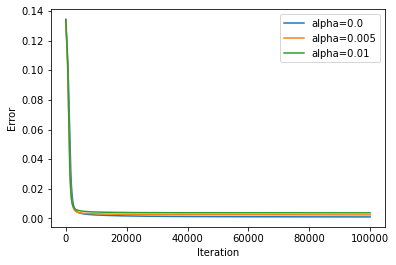

In [ ]:
for i in range(Alpha.shape[0]):
  plt.plot(Error[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()


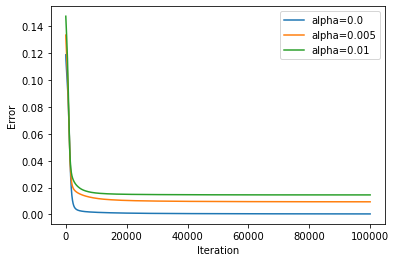

In [ ]:
for i in range(Alpha.shape[0]):
  plt.plot(Loss[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()


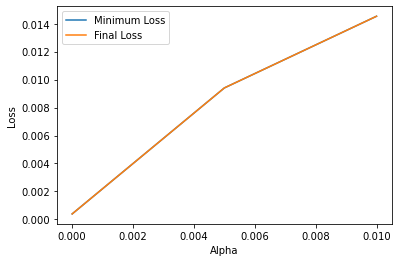

In [ ]:
plt.plot(Alpha, np.min(Loss, axis=1), label="Minimum Loss")
plt.plot(Alpha, Loss[:,-1], label="Final Loss")

plt.xlabel("Alpha")
plt.ylabel("Loss")

plt.legend()
plt.show()


  0%|          | 0/100000 [00:00<?, ?it/s]

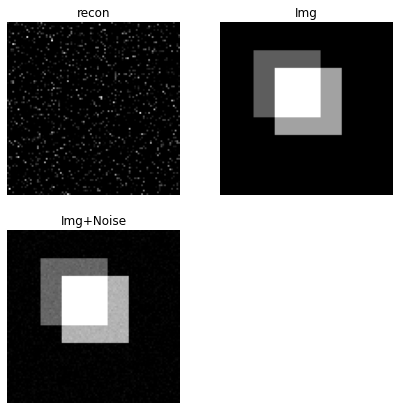

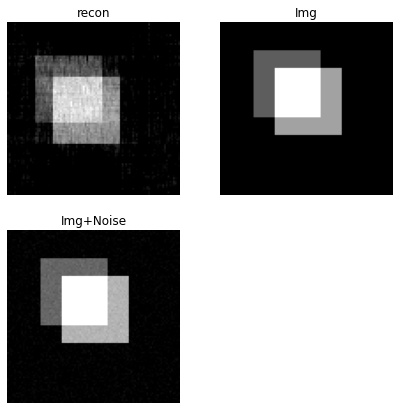

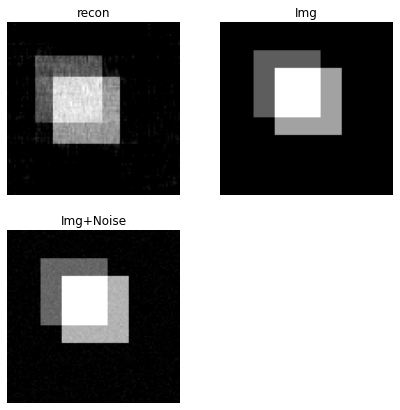

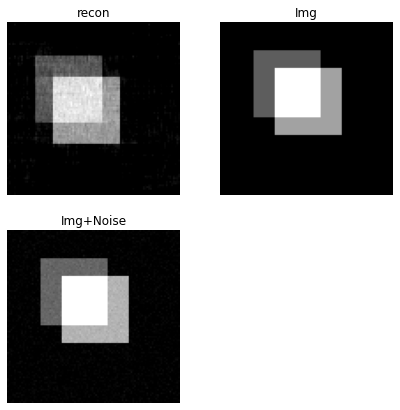

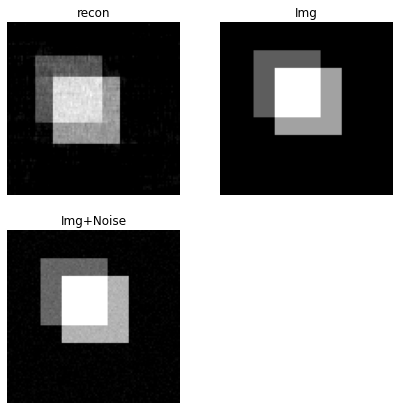

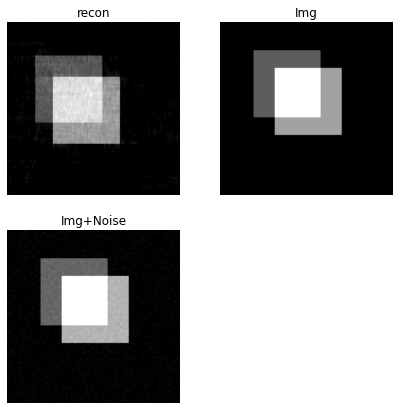

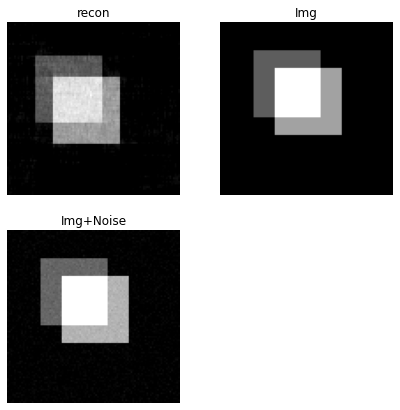

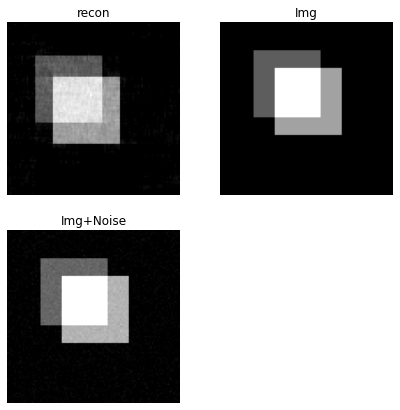

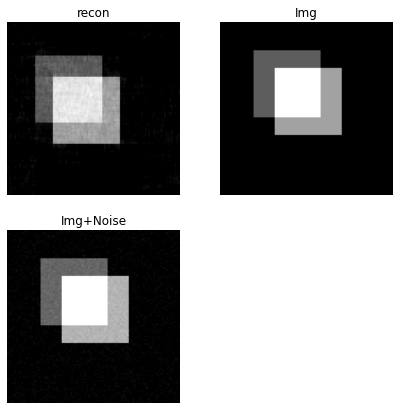

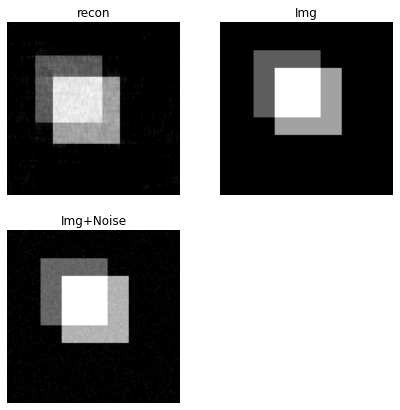

ending optimization in: 13.324 mins


In [ ]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.001, iterations=100000) #channel 8 ## circular padding ##noise=0.02

Text(0.5, 1.0, 'Plot of singular values')

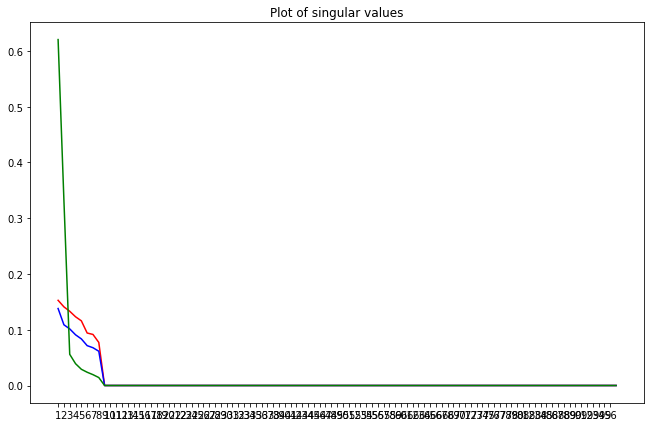

In [ ]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "red" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "blue" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "green" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'Plot of singular values')

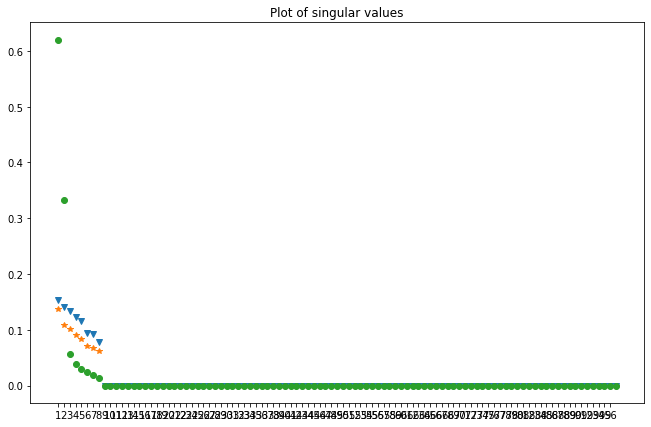

In [ ]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "v" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "*" )
  #plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[25000], "x" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'singular values')

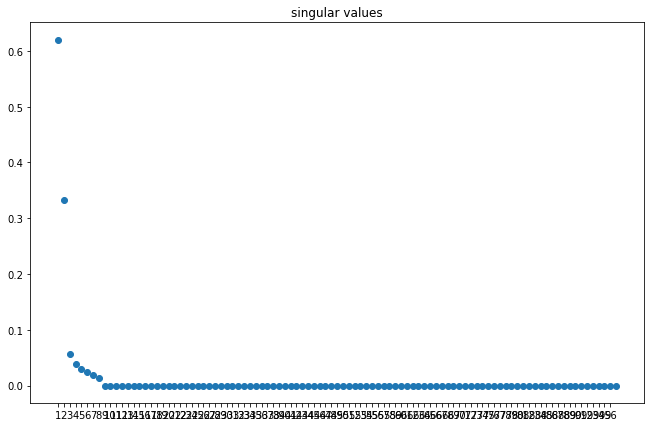

In [ ]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" )
plt.xticks(np.arange(1, len(S_values[0] + 1)))
#plt.yscale("log")
plt.title("singular values")

In [ ]:
kernel=UV_outer[99000].cpu().detach()

In [ ]:
kernel.shape

torch.Size([97, 97])

In [ ]:
kernel

tensor([[-0.0037, -0.0060, -0.0086,  ..., -0.0086, -0.0064, -0.0063],
        [-0.0035, -0.0060, -0.0092,  ..., -0.0085, -0.0060, -0.0065],
        [-0.0055, -0.0070, -0.0096,  ..., -0.0098, -0.0079, -0.0079],
        ...,
        [-0.0046, -0.0062, -0.0083,  ..., -0.0085, -0.0067, -0.0063],
        [-0.0057, -0.0074, -0.0102,  ..., -0.0106, -0.0086, -0.0086],
        [-0.0034, -0.0047, -0.0065,  ..., -0.0066, -0.0051, -0.0050]])

In [ ]:
_,Sigma,_=torch.svd_lowrank(kernel, q=8, niter=2, M=None)

Text(0.5, 1.0, 'singular values')

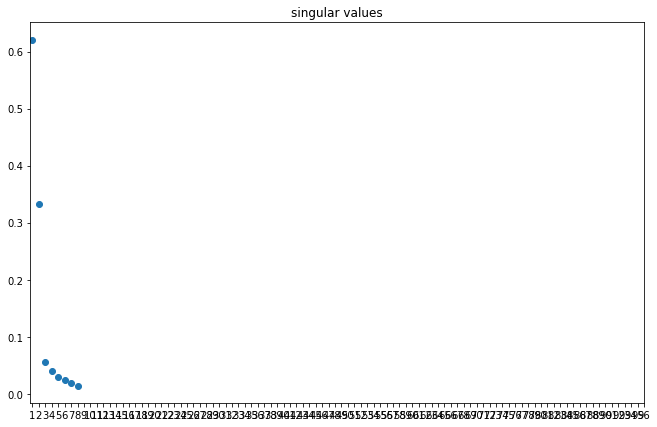

In [ ]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(Sigma) + 1),Sigma, "o" )
plt.xticks(np.arange(1, 97))
#plt.yscale("log")
plt.title("singular values")

In [ ]:
rec_f=Recons[99000].cpu().detach()

In [ ]:
rec_f.shape

torch.Size([1, 1, 98, 98])

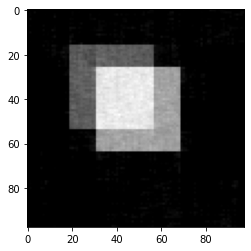

In [ ]:
plt.imshow(rec_f[0][0], cmap="gray")

In [ ]:
U, s, V = np.linalg.svd(rec_f[0][0], full_matrices=False)

Text(0.5, 1.0, 'singular values')

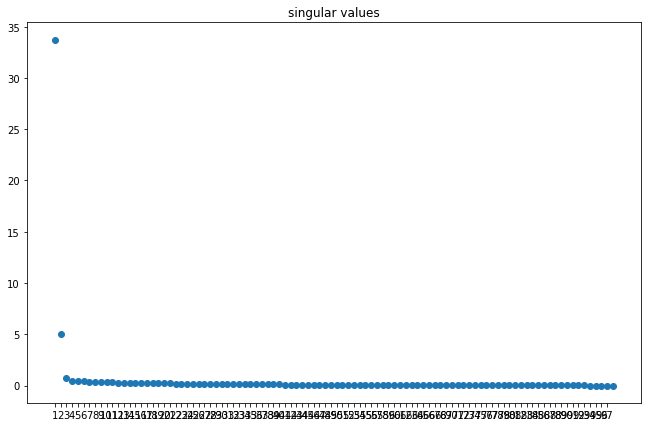

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("singular values")

In [ ]:
UV_outer

In [ ]:
UV_kernel=UV_outer[99000].cpu().detach()

In [ ]:
UV_kernel.shape

torch.Size([97, 97])

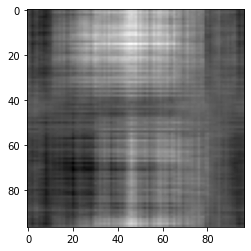

In [ ]:
plt.imshow(UV_kernel, cmap="gray")

In [ ]:
U, s, V = np.linalg.svd(UV_kernel, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

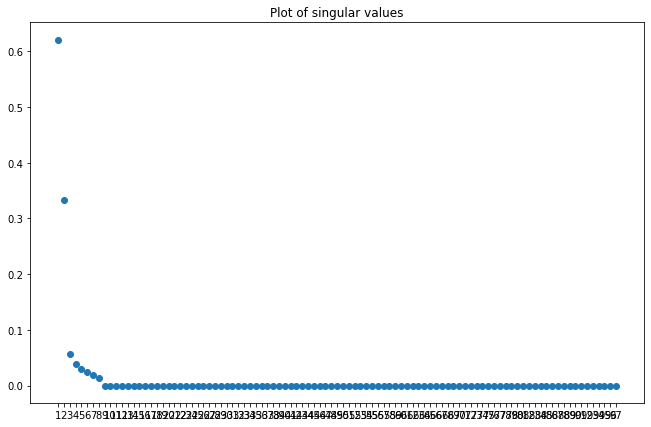

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
UV_kernel=np.array(UV_kernel)

In [ ]:
UV_kernel.shape

(97, 97)

In [ ]:
UV_kernel_transformed= np.fft.fft2(UV_kernel, axes=[0,1])

In [ ]:
U, s, V = np.linalg.svd(UV_kernel_transformed, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

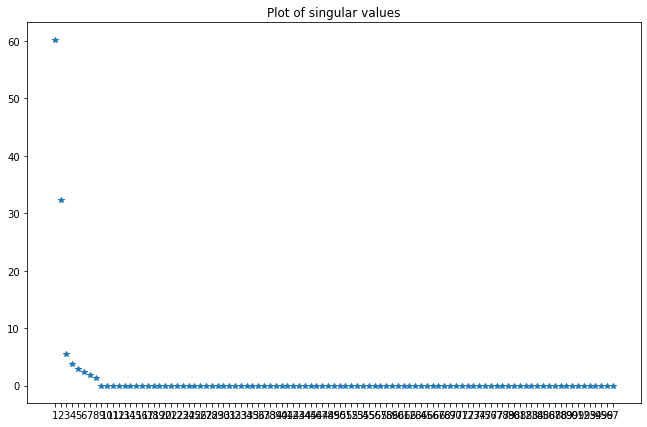

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "*" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
U, s, V = np.linalg.svd(noisyImg, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

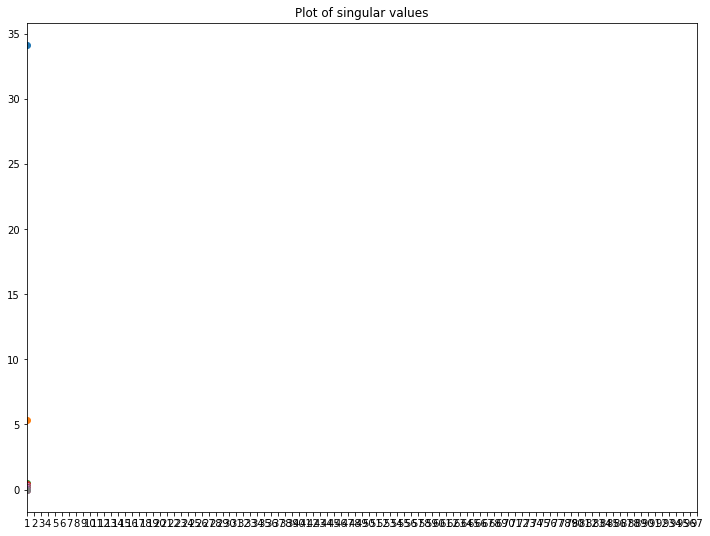

In [ ]:
plt.figure(figsize= (12,9))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
Nuc

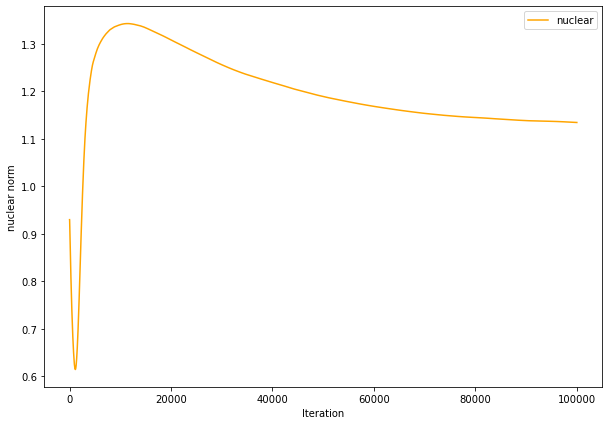

In [ ]:
## nuclear norm
plt.figure(figsize=(10, 7))
plt.plot(Nuc, color='orange', label='nuclear')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('nuclear norm')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()

In [ ]:
norm2

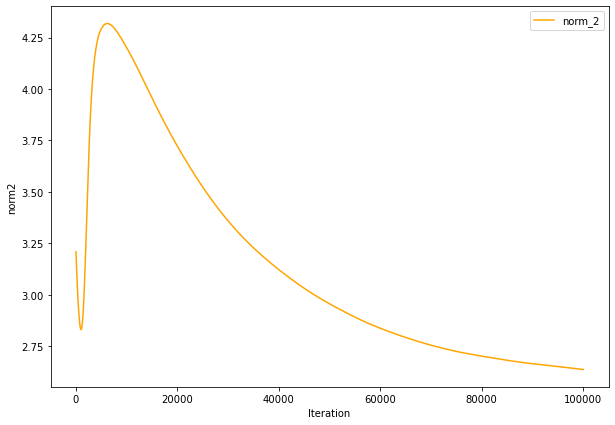

In [ ]:
## 2 norm
plt.figure(figsize=(10, 7))
plt.plot(norm2, color='orange', label='norm_2')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('norm2')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()